# Análise Estatística de Dados e Informações
**PPCA/UNB**

---

**Tarefa 04**  
**Professor**: João Gabriel de Moraes Sousa  
**Aluna**: Andreia Queiroz Correia Dummar  
**Matrícula**: 241134680  
**Data da Entrega**: 12/01/2025  
**Github**: https://github.com/aqcorreia/AEDI/tree/3e6a999ac003892ea0a9a114b694eed1b5fca9dd/Tarefa05

---

**Aplicação**: Regressão Logística

**Dados**: Retenção de Clientes em Unidades Bancárias (https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction/input)

## 1) Bibliotecas

In [1]:
# --- Bibliotecas para manipulação de dados ---
import pandas as pd
import numpy as np

# --- Bibliotecas para visualização ---
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Bibliotecas para pré-processamento ---
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- Bibliotecas para modelagem e validação ---
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
)

# --- Bibliotecas para análise estatística ---
from statsmodels.api import Logit, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Bibliotecas para balanceamento de classes ---
from imblearn.over_sampling import SMOTE


## 2) Leitura do arquivo Churn_Modelling.csv

In [2]:
diretorio = './dados'
churn_modelling_data = pd.read_csv(f'{diretorio}/Churn_Modelling.csv', delimiter=',')

churn_modelling_data.shape

(10000, 14)

## 3) Análise exploratória

In [3]:
churn_modelling_data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
churn_modelling_data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
churn_modelling_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 3) Modelo de regressão logística

#### 3.1) Identificando as variáveis mais significativas para o modelo de regressão logística

In [6]:
# Selecionar as colunas relevantes
X = churn_modelling_data[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']]
y = churn_modelling_data['Exited']

# Definir variáveis categóricas e numéricas
categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 
                      'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# Criar transformadores para numéricas e categóricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Preencher valores ausentes com a média
    ('scaler', StandardScaler())  # Escalar variáveis numéricas
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Preencher valores ausentes com a moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar variáveis categóricas
])

# Combinar os transformadores em um ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Criar pipeline completo com preprocessador e modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
pipeline.fit(X_train, y_train)

# Fazer previsões
y_pred = pipeline.predict(X_test)

# # Avaliar o modelo
# accuracy = accuracy_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
# class_report = classification_report(y_test, y_pred)

# # Imprimir resultados
# print("Acurácia do modelo:", accuracy)
# print("Matriz de Confusão:\n", conf_matrix)
# print("Relatório de Classificação:\n", class_report)

# Obter os coeficientes do modelo
classifier = pipeline.named_steps['classifier']
print("Coeficientes do modelo (variáveis numéricas):\n", classifier.coef_)
print("Intercepto do modelo:\n", classifier.intercept_)


Coeficientes do modelo (variáveis numéricas):
 [[-0.06761796  0.75459581 -0.04277161  0.16108649 -0.06038615 -0.01026438
  -0.53370066  0.01567551 -0.56898912  0.20925146 -0.47573914 -0.15176773
  -0.68370908]]
Intercepto do modelo:
 [-0.84408472]


---
#### Análise
1. **CreditScore (\(-0.0676\))**: Um maior crédito reduz levemente a probabilidade de saída.  
2. **Age (\(0.7546\))**: Clientes mais velhos têm maior probabilidade de sair.  
3. **Tenure (\(-0.0428\))**: Um tempo maior no banco reduz ligeiramente a probabilidade de saída.  
4. **Balance (\(0.1611\))**: Um saldo maior está associado a uma probabilidade levemente maior de saída.  
5. **NumOfProducts (\(-0.0604\))**: Um maior número de produtos reduz moderadamente a chance de saída.  
6. **HasCrCard (\(-0.0103\))**: Ter cartão de crédito não influencia significativamente na saída.  
7. **IsActiveMember (\(-0.5337\))**: Ser um membro ativo reduz consideravelmente a probabilidade de saída.  
8. **EstimatedSalary (\(0.0157\))**: O salário estimado tem impacto irrelevante na saída.  

---

##### Diferença entre os Impactos de `CreditScore` e `NumOfProducts`
Embora os coeficientes de `CreditScore` (\(-0.0676\)) e `NumOfProducts` (\(-0.0604\)) sejam próximos, o impacto de cada variável no modelo é percebido de forma diferente devido a dois fatores principais:

1. **Escala das Variáveis**:
   - **`CreditScore`**: Varia em uma escala ampla (e.g., 300 a 850), de modo que o impacto de pequenas mudanças no coeficiente é diluído.  
   - **`NumOfProducts`**: Geralmente varia em uma escala pequena (e.g., 1 a 4), então cada unidade adicional gera um impacto mais evidente.

2. **Interpretação Contextual**:
   - **`CreditScore`**: É uma métrica contínua, cuja influência no comportamento do cliente é mais difusa e menos diretamente relacionada à decisão de saída.  
   - **`NumOfProducts`**: Reflete o envolvimento do cliente com o banco; mais produtos indicam maior fidelidade, reduzindo a probabilidade de saída de forma mais significativa.

---

##### Conclusão
Os fatores mais importantes são **Age (aumenta a saída)** e **IsActiveMember (reduz a saída)**, seguidos por **Balance** e **NumOfProducts**s. A diferença na escala e no contexto das variáveis explica por que `NumOfProducts` apresenta um impacto moderado, enquanto `CreditScore` reduz levemente a probabilidade de saída.

Com isso, será gerado o modelo considerando as variáveis: **Age, IsActiveMember, Balance e NumOfProducts**.

---



#### 3.2) Gerando o modelo com as variáveis mais significativas

In [7]:
# Selecionar as colunas relevantes
X = churn_modelling_data[['Age', 'IsActiveMember', 'Balance', 'NumOfProducts']]
y = churn_modelling_data['Exited']

# Tratar valores ausentes, se houver
X = X.fillna(X.mean())

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciar o modelo de regressão logística
model = LogisticRegression(max_iter=1000)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibir os resultados
print("Acurácia do modelo:", accuracy)
print("Matriz de Confusão:\n", conf_matrix)
print("Relatório de Classificação:\n", class_report)

# Exibir os coeficientes do modelo
print("Coeficientes do modelo:", model.coef_)
print("Intercepto do modelo:", model.intercept_)


Acurácia do modelo: 0.81
Matriz de Confusão:
 [[1563   44]
 [ 336   57]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1607
           1       0.56      0.15      0.23       393

    accuracy                           0.81      2000
   macro avg       0.69      0.56      0.56      2000
weighted avg       0.77      0.81      0.76      2000

Coeficientes do modelo: [[ 7.18765402e-02 -1.07409821e+00  4.82676545e-06 -3.15008114e-02]]
Intercepto do modelo: [-4.1539257]


---

### Análise do Modelo de Regressão Logística

O modelo apresenta uma acurácia de 81% e um pseudo R² de 0.1259, indicando que explica cerca de 12.59% da variação na variável dependente. A matriz de confusão destaca o excelente desempenho na classe 0 (\(Recall = 97\%\)), enquanto o desempenho na classe 1 é insatisfatório (\(Recall = 15\%\)).

Os coeficientes mostram que a variável IsActiveMember tem o maior impacto negativo -1.07409821, Age (0.07187654) e NumOfProducts (-0.03150081) possuem impactos pequenos, e Balance (0.00000483) tem impacto insignificante.


---


#### 3.3) Validando os pressupostos da regressão logística para o modelo

##### 3.3.1) Linearidade entre as variáveis independentes e o logit

Optimization terminated successfully.
         Current function value: 0.443990
         Iterations 6


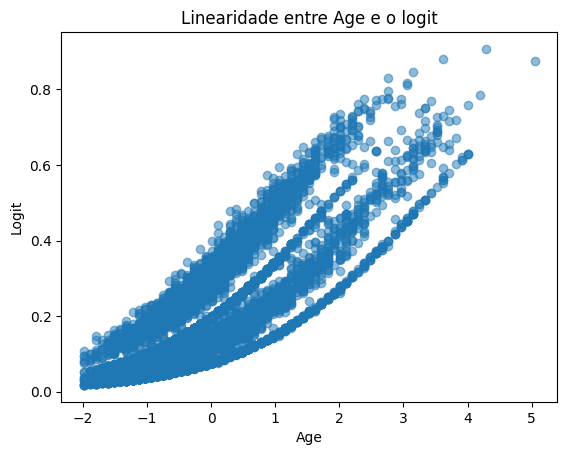

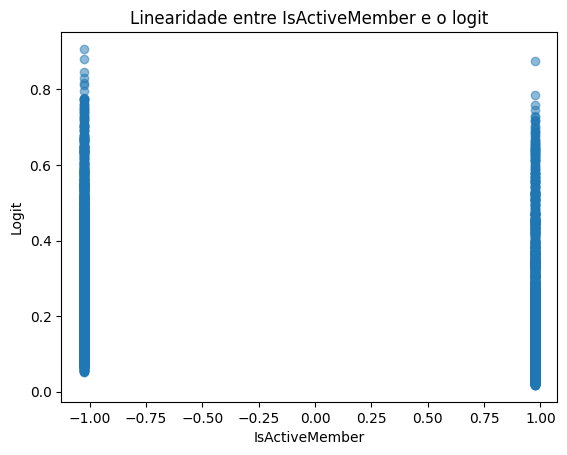

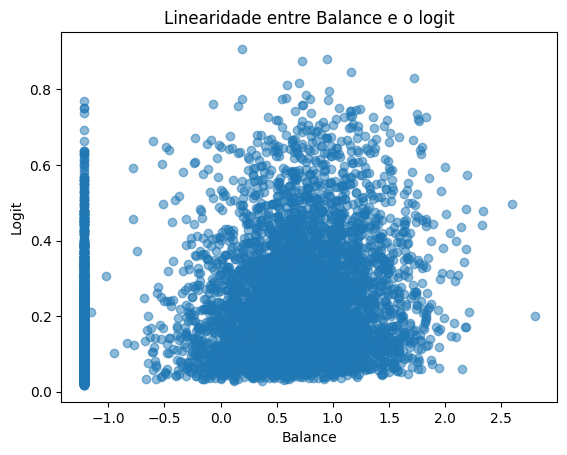

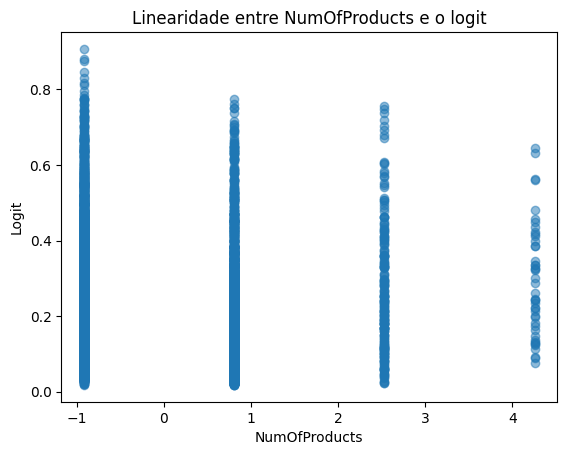

                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7995
Method:                           MLE   Df Model:                            4
Date:                Sun, 12 Jan 2025   Pseudo R-squ.:                  0.1259
Time:                        20:55:37   Log-Likelihood:                -3551.9
converged:                       True   LL-Null:                       -4063.5
Covariance Type:            nonrobust   LLR p-value:                3.531e-220
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.5905      0.033    -47.758      0.000      -1.656      -1.525
Age                0.7566      0.030     25.615      0.000       0.699       0.814
IsActiveMember    -0.5390      0.032

In [8]:
# Selecionar variáveis independentes e dependente
X = churn_modelling_data[['Age', 'IsActiveMember', 'Balance', 'NumOfProducts']]
y = churn_modelling_data['Exited']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar as variáveis numéricas
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

# Adicionar constante para statsmodels
X_train_scaled = add_constant(X_train_scaled)

# Garantir alinhamento dos índices entre X e y
X_train_scaled = X_train_scaled.loc[y_train.index]

# Ajustar o modelo logístico com statsmodels
logit_model = Logit(y_train, X_train_scaled)
result = logit_model.fit()

# Obter os log-odds para verificar linearidade
predicted_logit = result.predict(X_train_scaled)

# Verificar a relação linear entre cada variável e o logit
for col in X_train_scaled.columns[1:]:  # Exclui a constante
    plt.figure()
    plt.scatter(X_train_scaled[col], predicted_logit, alpha=0.5)
    plt.title(f"Linearidade entre {col} e o logit")
    plt.xlabel(col)
    plt.ylabel("Logit")
    plt.show()

# Exibir resumo do modelo
print(result.summary())


##### 3.3.2) Multicolinearidade

In [9]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(data):
    """
    Calcula o Variance Inflation Factor (VIF) para avaliar multicolinearidade.
    
    Parâmetros:
        data (DataFrame): DataFrame contendo as variáveis independentes.
        
    Retorna:
        DataFrame: Contém o nome das variáveis e seus respectivos VIFs.
    """
    # Adiciona uma constante ao conjunto de dados para o cálculo do VIF
    data_with_const = add_constant(data)
    
    # Calcula o VIF para cada variável
    vif_data = pd.DataFrame({
        'Variable': data_with_const.columns,
        'VIF': [variance_inflation_factor(data_with_const.values, i) 
                for i in range(data_with_const.shape[1])]
    })
    
    # Remove a constante da tabela final
    vif_data = vif_data[vif_data['Variable'] != 'const']
    
    return vif_data

# Exemplo de uso
# Suponha que X_train_scaled seja o DataFrame das variáveis independentes normalizadas
X_train_df = pd.DataFrame(X_train_scaled, columns=['Age', 'IsActiveMember', 'Balance', 'NumOfProducts'])

# Calcula os VIFs
vif_result = calculate_vif(X_train_df)

# Exibe os resultados
print("Variance Inflation Factor (VIF):")
print(vif_result)


Variance Inflation Factor (VIF):
         Variable       VIF
1             Age  1.009526
2  IsActiveMember  1.008698
3         Balance  1.097937
4   NumOfProducts  1.098246


#### 3.3.3) Avaliando o desbalanceamento

Frequência Absoluta:
Exited
0    6356
1    1644
Name: count, dtype: int64

Frequência Relativa (%):
Exited
0    79.45
1    20.55
Name: proportion, dtype: float64


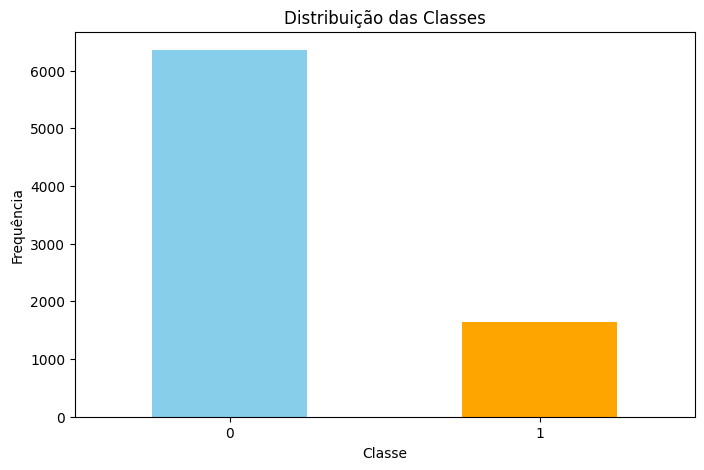

In [10]:
def verificar_desbalanceamento(y):
    """
    Verifica o desbalanceamento de classes em uma variável dependente e plota a distribuição.

    Parâmetros:
        y (pd.Series ou np.array): Variável dependente contendo as classes.

    Retorna:
        dict: Frequência absoluta e relativa de cada classe.
    """
    # Calcula a frequência absoluta e relativa
    freq_absoluta = pd.Series(y).value_counts()
    freq_relativa = pd.Series(y).value_counts(normalize=True) * 100

    # Exibe os resultados
    print("Frequência Absoluta:")
    print(freq_absoluta)
    print("\nFrequência Relativa (%):")
    print(freq_relativa)

    # Plotando a distribuição
    plt.figure(figsize=(8, 5))
    freq_absoluta.plot(kind='bar', color=['skyblue', 'orange'])
    plt.title("Distribuição das Classes")
    plt.xlabel("Classe")
    plt.ylabel("Frequência")
    plt.xticks(rotation=0)
    plt.show()

    return {"Frequência Absoluta": freq_absoluta, "Frequência Relativa (%)": freq_relativa}

# Exemplo de uso
# Suponha que y seja a variável dependente contendo as classes
y_train_series = pd.Series(y_train)  # Transformando y_train em série caso necessário
resultado = verificar_desbalanceamento(y_train_series)


---

### Análise dos pressupostos da regressão logística (linearidade entre as variáveis independentes e o logit, ausência de multicolinearidade e balanceamento da variável dependente (Exited)

#### Linearidade entre as variáveis independentes e o logit

O modelo apresenta um **pseudo R² de 0.1259**, indicando que o modelo explica cerca de 12.59% da variação na variável dependente (\(Exited\)). O pseudo \(R^2\) é uma medida de ajuste específica para modelos de classificação, que avalia a proporção da variação explicada em relação a um modelo nulo (sem preditores).

As variáveis **`Age`** (\(coef = 0.7566\)), **`IsActiveMember`** (\(coef = -0.5390\)) e **`Balance`** (\(coef = 0.3015\)) são estatisticamente significativas (\(P < 0.05\)), impactando a probabilidade de saída. Já **`NumOfProducts`** não é relevante (\(P = 0.540\)).

#### Multicolinearidade

Os valores de **Variance Inflation Factor (VIF)** indicam que todas as variáveis possuem VIF próximo de 1, sugerindo **baixa correlação** entre as variáveis independentes. Isso confirma que **não há multicolinearidade significativa** no modelo, e todas as variáveis podem ser mantidas. O modelo é adequado nesse aspecto.

#### Balanceamento da variável dependente (Exited)

O conjunto de dados apresenta um **desbalanceamento**, com 79.45% das observações na classe 0 (\(Exited = 0\)) e apenas 20.55% na classe 1 (\(Exited = 1\)). Esse desbalanceamento pode dificultar a detecção da classe minoritária.

#### Conclusão

Será realizado um balanceamento de classes com SMOTE e será removida a variável NumOfProducts do modelo

---


#### 3.4) Executando o modelo após o balanceamento com SMOTE

In [11]:
# Dados simulados (substituir com churn_modelling_data)
# X contém as variáveis independentes, y é a variável dependente
X = churn_modelling_data[['Age', 'IsActiveMember', 'Balance']]
y = churn_modelling_data['Exited']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizando as variáveis independentes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicando SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# **Modelo 1: Random Forest**
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model.fit(X_train_balanced, y_train_balanced)

# Avaliando o Random Forest
rf_y_pred = rf_model.predict(X_test_scaled)
rf_y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Random Forest - Confusion Matrix:\n", confusion_matrix(y_test, rf_y_pred))
print("\nRandom Forest - Classification Report:\n", classification_report(y_test, rf_y_pred))
print("Random Forest - AUC:", roc_auc_score(y_test, rf_y_prob))

# **Modelo 2: Gradient Boosting**
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)
gb_model.fit(X_train_balanced, y_train_balanced)

# Avaliando o Gradient Boosting
gb_y_pred = gb_model.predict(X_test_scaled)
gb_y_prob = gb_model.predict_proba(X_test_scaled)[:, 1]

print("\nGradient Boosting - Confusion Matrix:\n", confusion_matrix(y_test, gb_y_pred))
print("\nGradient Boosting - Classification Report:\n", classification_report(y_test, gb_y_pred))
print("Gradient Boosting - AUC:", roc_auc_score(y_test, gb_y_prob))


Random Forest - Confusion Matrix:
 [[1282  311]
 [ 203  204]]

Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1593
           1       0.40      0.50      0.44       407

    accuracy                           0.74      2000
   macro avg       0.63      0.65      0.64      2000
weighted avg       0.77      0.74      0.75      2000

Random Forest - AUC: 0.6987349444976563

Gradient Boosting - Confusion Matrix:
 [[1229  364]
 [ 134  273]]

Gradient Boosting - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      1593
           1       0.43      0.67      0.52       407

    accuracy                           0.75      2000
   macro avg       0.67      0.72      0.68      2000
weighted avg       0.81      0.75      0.77      2000

Gradient Boosting - AUC: 0.790869451886401


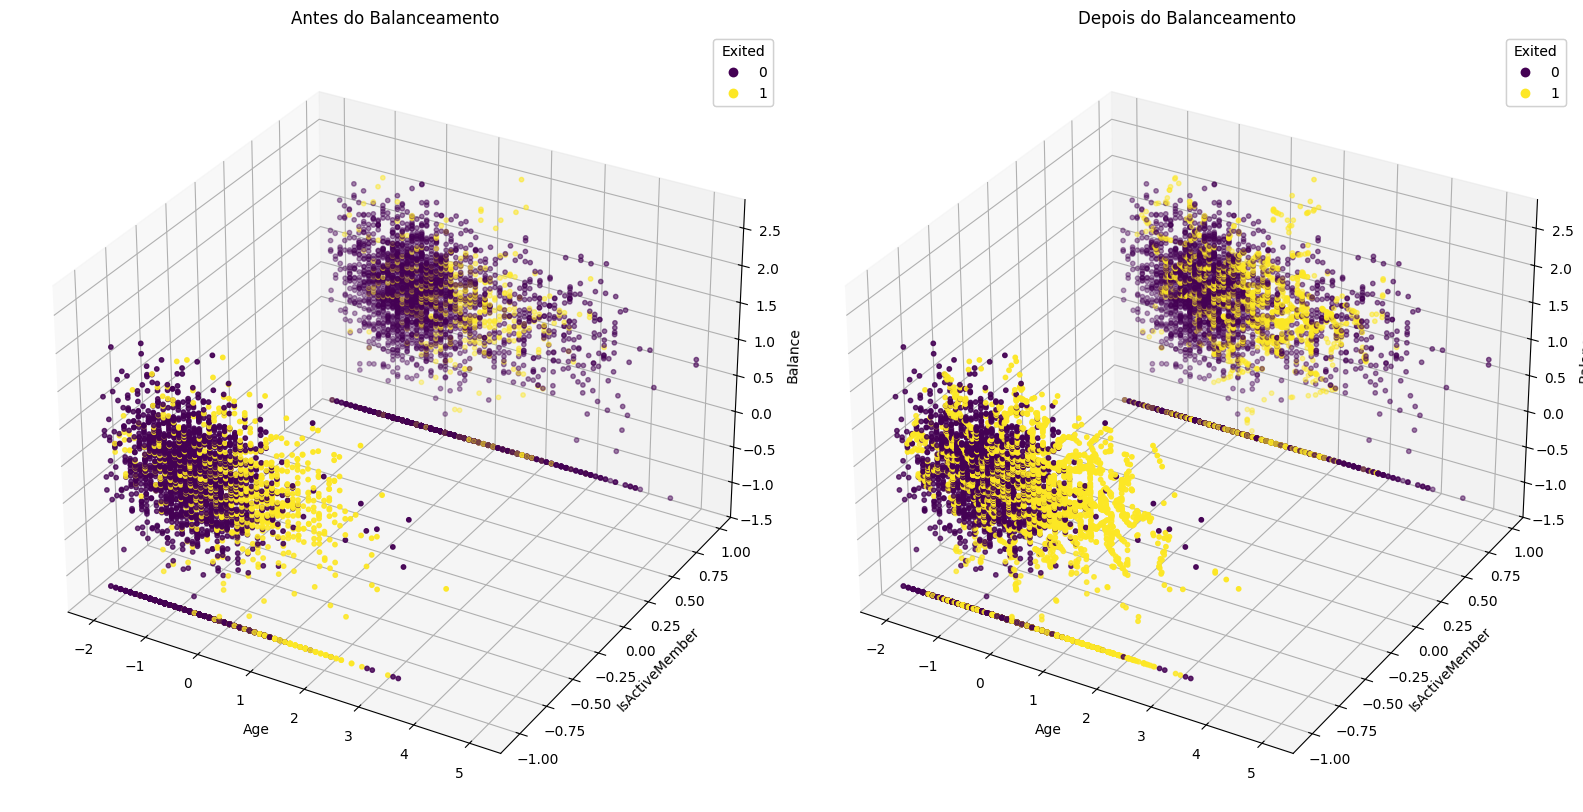

In [12]:
# Função para plotar gráficos 3D de antes e depois do balanceamento
def plot_3d_before_after(X_before, y_before, X_after, y_after):
    fig = plt.figure(figsize=(16, 8))

    # Gráfico antes do balanceamento
    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.scatter(
        X_before[:, 0], X_before[:, 1], X_before[:, 2],
        c=y_before, cmap='viridis', s=10
    )
    ax1.set_title("Antes do Balanceamento")
    ax1.set_xlabel("Age")
    ax1.set_ylabel("IsActiveMember")
    ax1.set_zlabel("Balance")
    legend1 = ax1.legend(*scatter1.legend_elements(), title="Exited")
    ax1.add_artist(legend1)

    # Gráfico depois do balanceamento
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(
        X_after[:, 0], X_after[:, 1], X_after[:, 2],
        c=y_after, cmap='viridis', s=10
    )
    ax2.set_title("Depois do Balanceamento")
    ax2.set_xlabel("Age")
    ax2.set_ylabel("IsActiveMember")
    ax2.set_zlabel("Balance")
    legend2 = ax2.legend(*scatter2.legend_elements(), title="Exited")
    ax2.add_artist(legend2)

    plt.tight_layout()
    plt.show()

# Selecionando as variáveis para o gráfico
X_before = X_train_scaled[:, :3]  # Variáveis independentes antes do balanceamento
y_before = y_train.values         # Variável dependente antes do balanceamento
X_after = X_train_balanced[:, :3] # Variáveis independentes após o balanceamento
y_after = y_train_balanced        # Variável dependente após o balanceamento

# Gerar os gráficos
plot_3d_before_after(X_before, y_before, X_after, y_after)


---

### Análise

#### Modelo Sem Balanceamento:
- **Acurácia:** 81% 
- **Matriz de Confusão:**
  - Classe 0: 1563 acertos (TN), 44 erros (FP).
  - Classe 1: 57 acertos (TP), 336 erros (FN).
- **Métricas Classe 1 (Minoritária):**
  - **Precision:** 56% — Apenas 56% das previsões de saída (\(Exited = 1\)) estão corretas.
  - **Recall:** 15% — Apenas 15% dos clientes que saíram foram corretamente identificados.
  - **F1-Score:** 23% — Indica desempenho fraco para a classe minoritária.
- **Conclusão:** O modelo é altamente enviesado para a classe majoritária (\(Exited = 0\)) devido ao desbalanceamento, com baixa capacidade de identificar a classe minoritária.

#### Modelo com Balanceamento

**Random Forest:**
- **Acurácia:** 74%
- **Matriz de Confusão:**
  - Classe 0: 1282 acertos (TN), 311 erros (FP).
  - Classe 1: 204 acertos (TP), 203 erros (FN).
- **Métricas Classe 1:**
  - **Precision:** 40%, **Recall:** 50%, **F1-Score:** 44%.
- **AUC:** 0.6987 — Indica desempenho moderado para separar as classes.

**Gradient Boosting:**
- **Acurácia:** 75%
- **Matriz de Confusão:**
  - Classe 0: 1229 acertos (TN), 364 erros (FP).
  - Classe 1: 273 acertos (TP), 134 erros (FN).
- **Métricas Classe 1:**
  - **Precision:** 43%, **Recall:** 67%, **F1-Score:** 52%.
- **AUC:** 0.7909 — Melhor discriminação entre as classes em comparação com o Random Forest.

---

### Comparação Geral

- O modelo **sem balanceamento** é fortemente enviesado para a classe majoritária (\(Exited = 0\)), com **recall de apenas 15%** para a classe minoritária.
- Após aplicar o balanceamento:
  - **Gradient Boosting** apresenta melhor desempenho geral, especialmente na classe minoritária (\(Exited = 1\)), com **recall de 67%** e **AUC de 0.7909**.
  - **Random Forest** tem desempenho inferior, com **recall de 50%** e **AUC de 0.6987**.

---

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Melhores Hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Métricas de Avaliação do Modelo:
AUC: 0.7380
Precisão: 0.4352
Sensibilidade (Recall): 0.5283
Especificidade: 0.8249
Acurácia: 0.7645

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1593
           1       0.44      0.53      0.48       407

    accuracy                           0.76      2000
   macro avg       0.65      0.68      0.66      2000
weighted avg       0.78      0.76      0.77      2000



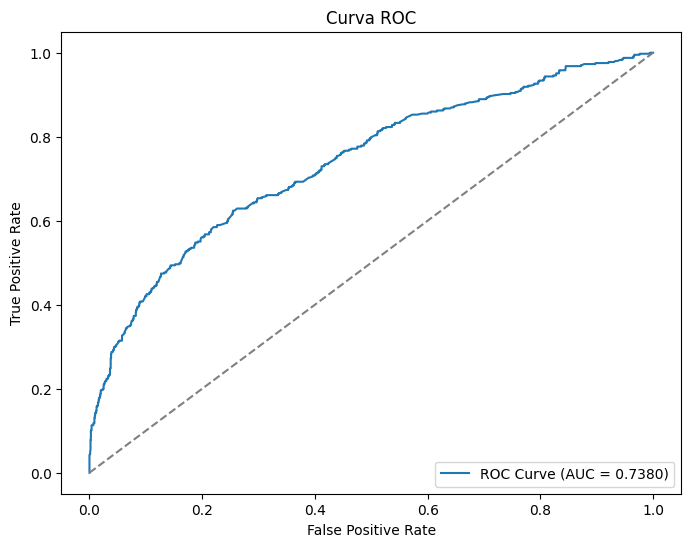

In [13]:
# 1. Função para ajustar o threshold de classificação e avaliar o modelo
def avaliar_modelo(model, X_test, y_test, threshold=0.5):
    """
    Avalia o desempenho do modelo ajustado com métricas como AUC, Curva ROC, precisão, sensibilidade e especificidade.
    """
    # Obter probabilidades previstas
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    # AUC e Curva ROC
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    # Métricas de Avaliação
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Sensibilidade
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Exibir Métricas
    print("Métricas de Avaliação do Modelo:")
    print(f"AUC: {auc:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Sensibilidade (Recall): {recall:.4f}")
    print(f"Especificidade: {specificity:.4f}")
    print(f"Acurácia: {accuracy:.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    # Plot da Curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()

# 2. Otimização de Hiperparâmetros com GridSearchCV
def otimizar_modelo(X_train, y_train):
    """
    Otimiza os hiperparâmetros do Gradient Boosting usando GridSearchCV.
    """
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }

    grid_search = GridSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    print("Melhores Hiperparâmetros:", grid_search.best_params_)
    return grid_search.best_estimator_

# 3. Ajustando o modelo com os melhores hiperparâmetros
best_gb_model = otimizar_modelo(X_train_balanced, y_train_balanced)

# 4. Avaliando o modelo otimizado
avaliar_modelo(best_gb_model, X_test_scaled, y_test, threshold=0.5)


---

### Análise 

#### Explicação das Métricas

1. **AUC e Curva ROC:**
   - A **AUC (Área sob a Curva)** reflete a capacidade do modelo de discriminar entre clientes que saíram (\(Exited = 1\)) e os que ficaram (\(Exited = 0\)).
   - Uma AUC maior significa que o modelo é melhor em distinguir corretamente entre as classes.

2. **Precisão:**
   - Mede a proporção de previsões corretas de saída (\(Exited = 1\)).
   - Alta precisão indica que, quando o modelo prevê saída, ele está geralmente correto.

3. **Sensibilidade (Recall):**
   - Mede a capacidade do modelo de identificar corretamente os clientes que realmente saíram.
   - É crucial para minimizar falsos negativos, garantindo que a maioria dos clientes propensos a sair seja detectada.

4. **Especificidade:**
   - Mede a capacidade do modelo de identificar corretamente os clientes que permaneceram (\(Exited = 0\)).
   - Alta especificidade reduz falsos positivos, garantindo que clientes leais não sejam indevidamente classificados como propensos a sair.

---

### Conclusão

O modelo **Gradient Boosting otimizado** oferece um equilíbrio entre precisão e recall, com **AUC de 0.7380** e **Recall da Classe 1 de 53%**, enquanto o **Gradient Boosting sem otimização** prioriza a detecção de clientes que saíram, com **AUC de 0.7909** e **Recall de 67%**. 

Ambos superam o **Random Forest** (AUC: 0.6987, Recall: 50%), sendo mais eficazes na discriminação entre as classes. A escolha do modelo depende do objetivo: equilíbrio geral ou maior recall para a classe minoritária.
